# Monitoring a Multiclass Classifier Model for NLP Data with Fiddler
Unstructured data such as text are usually represented as high-dimensional vectors when processed by ML models. In this example notebook we present how [Fiddler Vector Monitoring](https://www.fiddler.ai/blog/monitoring-natural-language-processing-and-computer-vision-models-part-1) can be used to monitor NLP models using a text classification use case.

We use the 20Newsgroups dataset and train a multi-class classifier applied to TF-IDF embedding vectors of text data. Data preparation and model training is done using [this notebook](https://colab.research.google.com/drive/12RuC0LOhafF4KTkBvo3sCfV-IOvS6rp-?usp=sharing), while labeled data is imported. We monitor this model at production time and assess the performance of Fiddler's vector monitoring by manufacturing synthetc drift via sampling from specific text categories at different deployment time intervals.

---

Now we perform the following steps to demonstrate how Fiddler NLP monitoring works: 

1. Connect to Fiddler and Create a Project
2. Upload the Assets
3. Upload Baseline Data to Fiddler
4. Add Metadata About the Model 
5. Manufacture Synthetic Data Drift and Publish Production Events
6. Get insights

## Imports

In [ ]:
import pandas as pd
import numpy as np

# 1. Connect to Fiddler and Create a Project

First we install and import the Fiddler Python client.

In [ ]:
!pip install -q fiddler-client
import fiddler as fdl
print(f"Running client version {fdl.__version__}")

Before you can add information about your model with Fiddler, you'll need to connect using our API client.

---

**We need a few pieces of information to get started.**
1. The URL you're using to connect to Fiddler
2. Your organization ID
3. Your authorization token

The latter two of these can be found by pointing your browser to your Fiddler URL and navigating to the **Settings** page.

In [ ]:
URL = ''  # Make sure to include the full URL (including https://).
ORG_ID = ''
AUTH_TOKEN = ''

Next we run the following code block to connect to the Fiddler API.

In [ ]:
client = fdl.FiddlerApi(
    url=URL,
    org_id=ORG_ID,
    auth_token=AUTH_TOKEN,
)

Once you connect, you can create a new project by specifying a unique project ID in the client's `create_project` function.

In [ ]:
PROJECT_ID = 'nlp_multiclass'

if not PROJECT_ID in client.list_projects():
    print(f'Creating project: {PROJECT_ID}')
    client.create_project(PROJECT_ID)
else:
    print(f'Project: {PROJECT_ID} already exists')

# 2. Upload the Assets

Now we retrieve the 20Newsgroup dataset together with the TF-IDF embedding of each data point and the predicted class probabilities computed by a logistic regression classifier for five different class labels: 'computer', 'forsale' 'recreation', 'religion', and 'science'. The data is generated by [this notebook](https://colab.research.google.com/drive/12RuC0LOhafF4KTkBvo3sCfV-IOvS6rp-?usp=sharing) which stores two data frames; a baseline data frame and a production data frame. The production events in specific time intervals will be sampled from the production data frame where additional filters are applied to mimic the real-world scenarios (e.g., sampling from a particular news topic in an interval). 

In [ ]:
DATA_PATH = 'https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/'

baseline_df = pd.read_csv(DATA_PATH + '20newsgroups_baseline')
production_df = pd.read_csv(DATA_PATH + '20newsgroups_production')

In [ ]:
embedding_col_names = [col for col in baseline_df.columns if col.startswith('tfidf_token')]
prediction_col_names= [col for col in baseline_df.columns if col.startswith('prob_')]
target_classes      = [col[5:] for col in prediction_col_names]

# 3. Upload Baseline Data to Fiddler

Now we create a [DatasetInfo](https://docs.fiddler.ai/reference/fdldatasetinfo) object to describe our baseline dataset.

In [ ]:
baseline_samples = baseline_df.copy()
dataset_info = fdl.DatasetInfo.from_dataframe(baseline_samples, max_inferred_cardinality=20)
dataset_info

Next we call the [upload_dataset()](https://docs.fiddler.ai/reference/clientupload_dataset) API to upload a baseline  to Fiddler. In addition to the baseline data, we also uploaded the whole production data framework as the 'test_data' dataset which allows us to look at the model performance metrics for unseen data.

In [ ]:
DATASET_ID = 'newsgroups_baseline'

if not DATASET_ID in client.list_datasets(project_id=PROJECT_ID):
    print(f'Upload dataset {DATASET_ID}')
    client.upload_dataset(
    project_id=PROJECT_ID,
    dataset_id=DATASET_ID,
    dataset={'baseline':baseline_samples,
             'test_data':production_df
            },
    info=dataset_info
)
else:
    print(f'Dataset: {DATASET_ID} already exists in Project: {PROJECT_ID}.\n'
               'The new dataset is not uploaded. (please use a different name.)') 

# 4. Add Metadata About the Model

Next we should tell Fiddler a bit more about our model by creating a [model_info](https://docs.fiddler.ai/reference/fdlmodelinfo) object that specifies the model's task, inputs, outputs, and other information such as the custom features and the targets for a multi-class classification model.

While Fiddler monitores all the 

Let's first show how custom features can be used to monitor vectors such as the NLP embeddings.

### Define Custom Features for Vector Monitoring

In addition to univariate numerical features which Fiddler monitored by default, users can define custom features and ask Fiddler to monitor them. A custom feature is specified by a group of dataset columns that need to be monitored together as a vector.

Before creating a model info object, we define a custom feature using the [CustomFeature.from_columns()](https://docs.fiddler.ai/reference/fdlcustomfeaturefrom_columns) API. When creating a custom feature, a name must be assigned to the custom feature using the `custom_name` argument. Each custom feature appears in the monitoring tab in Fiddler UI with this assigned name. Finally, the default clustering setup can be modified by passing the number of cluster centroids to the `n_clusters` argument.

Here we define a custom feature that is a vector whose elements are the tf-idf embedding columns in the dataset.

In [ ]:
CF1 = fdl.CustomFeature.from_columns(cols=embedding_col_names, n_clusters=6, custom_name='tfidf_vector')

### Generate ModelInfo Object and Add Model 

Since this notebook demonstrates a monitoring-only use case and model predictions are already added to both baseline and production data, there is no need to access the model directly or to build a surrogate model and we use the [add_model()](https://docs.fiddler.ai/reference/clientadd_model) API. This requires passing a [model_info](https://docs.fiddler.ai/reference/fdlmodelinfo) object which conitains information about our model's task, inputs, outputs, targets and custom features that we would like to be monitored.

In [ ]:
model_task = fdl.ModelTask.MULTICLASS_CLASSIFICATION
model_target = 'target'
model_outputs = prediction_col_names
model_features = embedding_col_names

model_info = fdl.ModelInfo.from_dataset_info(
    dataset_info=dataset_info,
    dataset_id=DATASET_ID,
    features=model_features,
    target=model_target,
    outputs=model_outputs,
    custom_features = [CF1],
    model_task=model_task,
    categorical_target_class_details=target_classes,
    metadata_cols=['original_text'],
    description='A multi-class calssifier for NLP data that uses text embeddings'
)
model_info

In [ ]:
MODEL_ID = 'multiclass_logistic_reg'

if not MODEL_ID in client.list_models(project_id=PROJECT_ID):
    client.add_model(
        project_id=PROJECT_ID,
        dataset_id=DATASET_ID,
        model_id=MODEL_ID,
        model_info=model_info
    )
else:
    print(f'Model: {MODEL_ID} already exists in Project: {PROJECT_ID}. Please use a different name.')

# 5. Manufacture Synthetic Data Drift and Publish Production Events

Now we publish some production events into Fiddler. We publish events in data batches and manually create data drift by sampling from particular newsgroups. This allows us to test the performance of Fiddler vector monitoring.

In [ ]:
batch_size = 400 #number of events per time bin
event_batches_df=[]

For sanity check, we use the baseline data as the first event batch

In [ ]:
event_batches_df.append(baseline_samples)

Next sample from all categories (same as baseline)

In [ ]:
n_intervals = 3
for i in range(n_intervals):
    event_batches_df.append(production_df.sample(batch_size))

Now we generate synthetic data drift by adding event batches that are sampled from specific newsgroups

In [ ]:
T1 = ['computer','science','recreation']
T2 = ['science','recreation']
T3 = ['recreation']
T4 = ['computer','science','religion','forsale']
T5 = ['forsale']
synthetic_intervals = [T1,T2,T3,T4,T5]

In [ ]:
for categories in synthetic_intervals:
    production_df_subset = production_df[production_df['target'].isin(categories)]
    event_batches_df.append(production_df_subset.sample(batch_size))

Add more batches sampled from all categories (no data drift)

In [ ]:
n_intervals = 3
for i in range(n_intervals):
    event_batches_df.append(production_df.sample(batch_size))

### Add Timestamp to Batches and Publish Events

In [ ]:
import time
daily_time_gap = 24*3600*1000 #daily time gap

In [ ]:
#start from 20 days back
timestamp=time.time()*1000 - 20*daily_time_gap
for event_df in event_batches_df:
    event_df['timestamp'] = timestamp
    timestamp += daily_time_gap

Publish events

In [ ]:
for event_df in event_batches_df:
    client.publish_events_batch(
        project_id=PROJECT_ID,
        model_id=MODEL_ID,
        batch_source=event_df,
        timestamp_field= 'timestamp' #comment this line if you are not adding timestamps
    )

# 6. Get insights


**You're all done!**
  
You can now head to your Fiddler environment and start getting enhanced observability into your model's performance.

In particular, you can go to charts and check the resulting drift chart for the TF-IDF embedding vectors. Below is a screenshot of the a data drift chart after running this notebook. The areas of higher drift correspond to the oversampling done above from certain newsgroup topics.  The areas of low drift correspond to the sampling done just from the baseline.

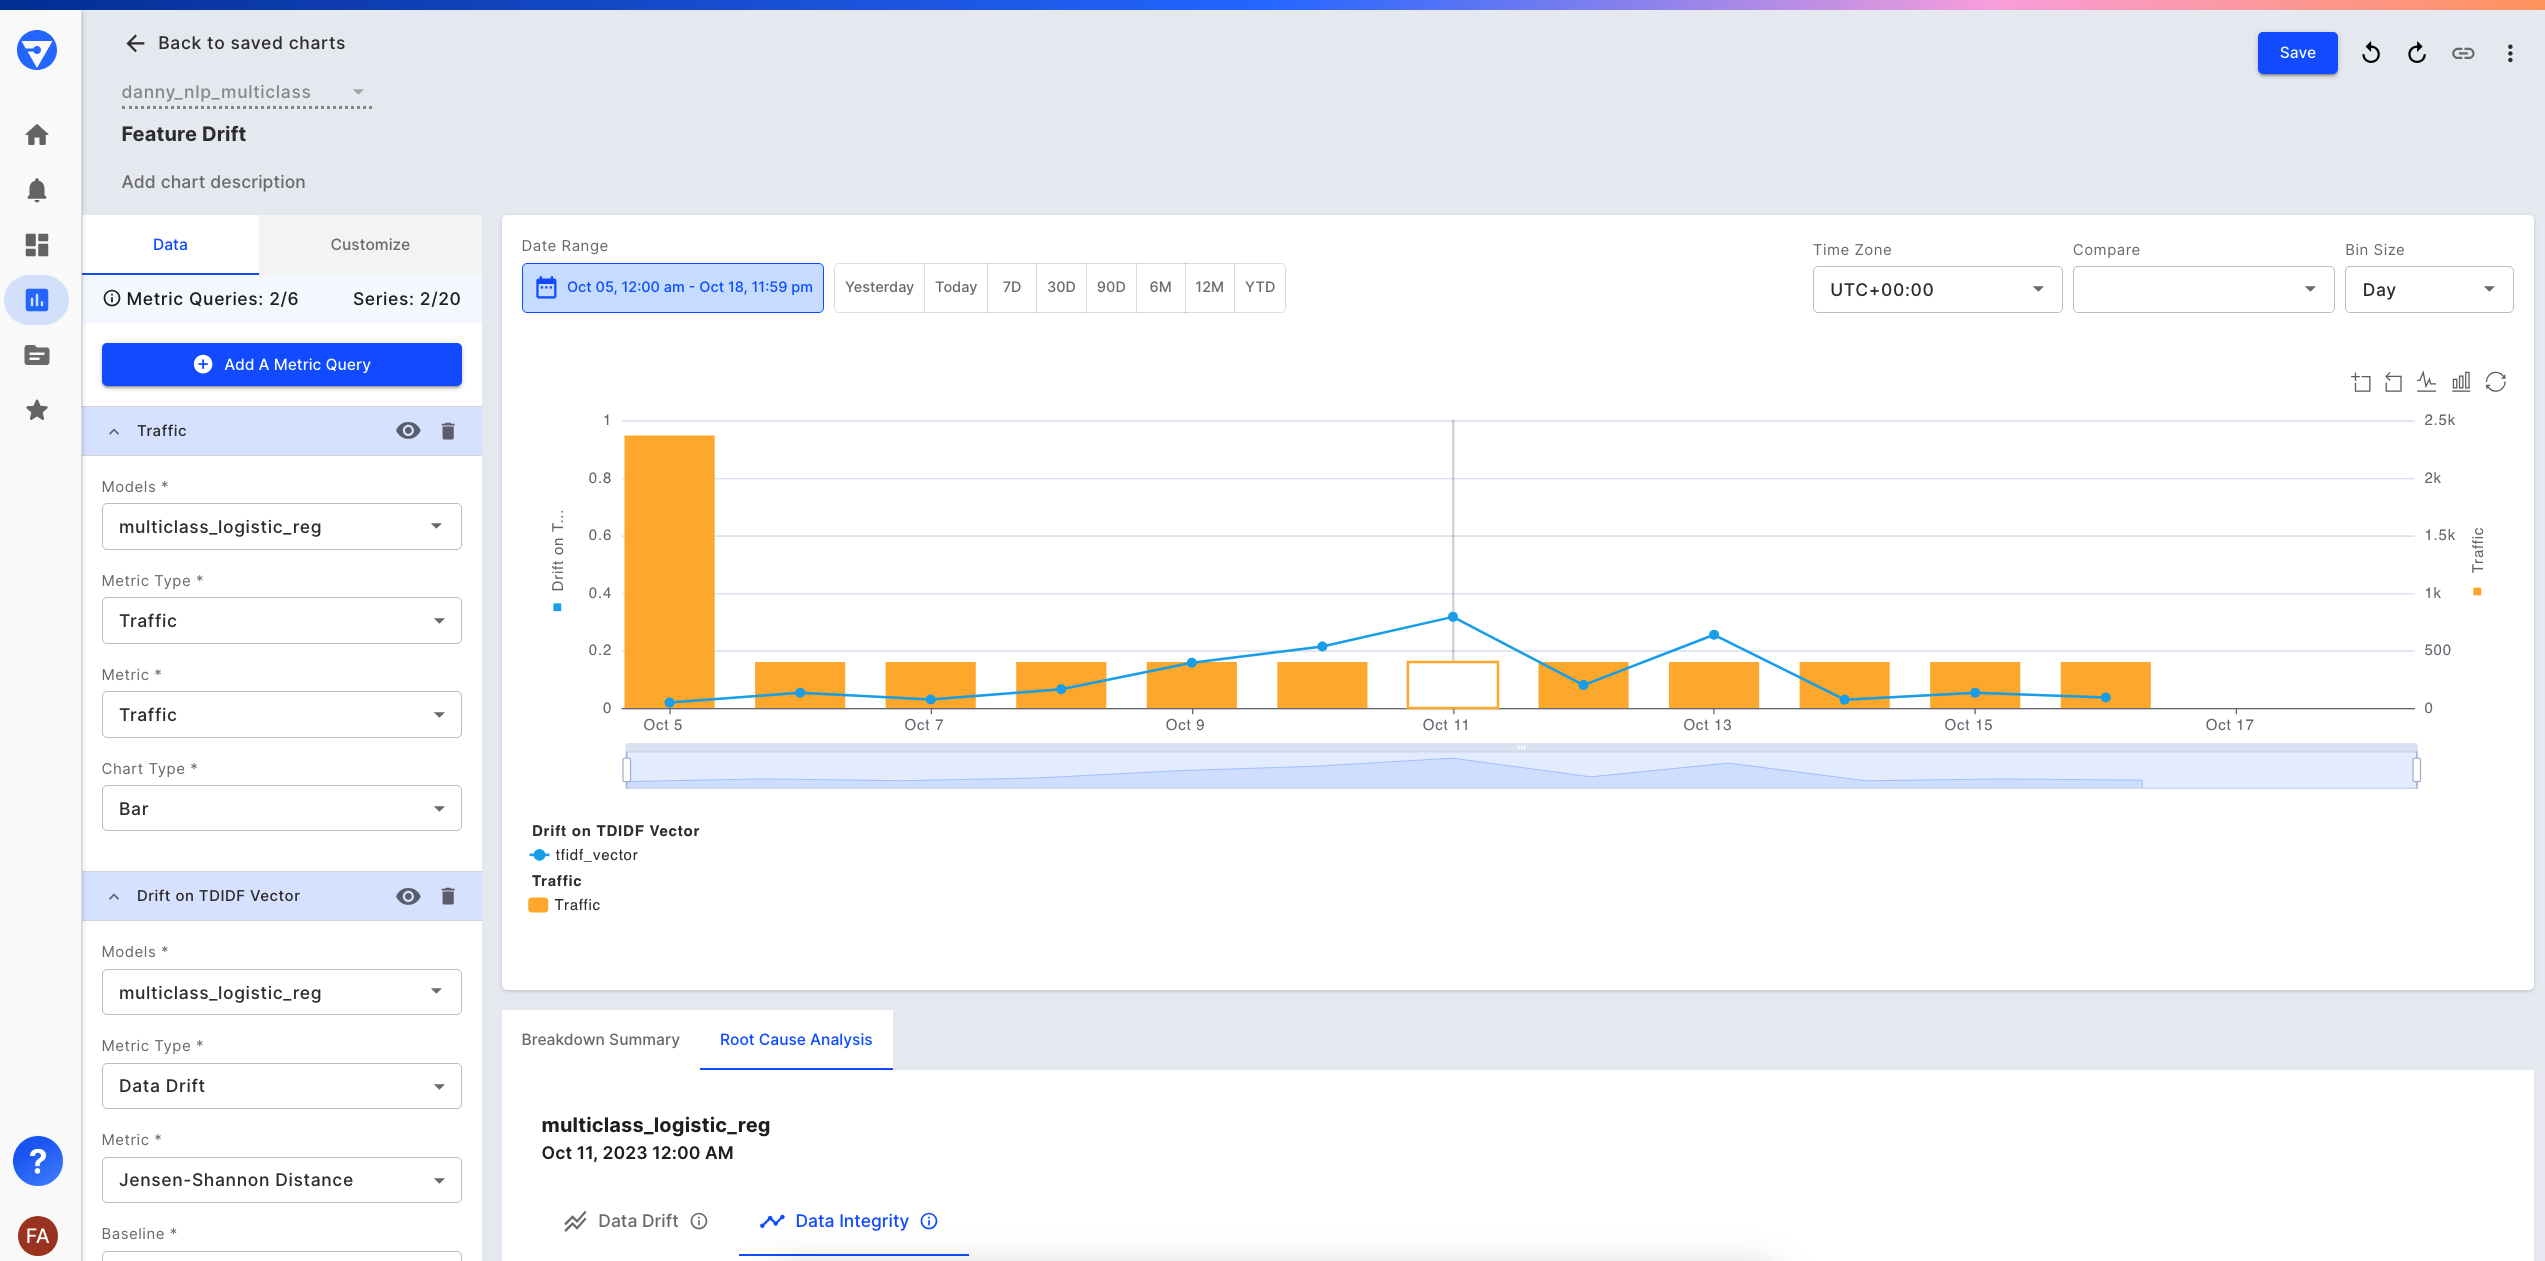